In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 
from matplotlib import dates as mdates
%matplotlib inline

In [2]:
# load data in
df = pd.read_csv("2015_event_data.csv", dtype={"Opponent": "string", "Player 0": "string", "Player 1": "string", 
                                                    "Player 2": "string", "Player 3": "string",
                                                    "Player 4": "string", "Player 5": "string",
                                                    "Player 6": "string", "Player 7": "string", 
                                                    "Player 8": "string", "Player 9": "string",
                                                    "Player 10": "string", "Player 11": "string",
                                                    "Player 12": "string", "Player 13": "string",
                                                    "Player 14": "string", "Player 15": "string",
                                                    "Player 16": "string", "Player 17": "string", 
                                                    "Player 18": "string", "Player 19": "string",
                                                    "Player 20": "string", "Player 21": "string",
                                                    "Player 22": "string", "Player 23": "string",
                                                    "Player 24": "string", "Player 25": "string",
                                                    "Player 26": "string", "Player 27": "string"})

In [3]:
# peek 
df.head()

,Unnamed: 0,Date/Time,Tournamemnt,Opponent,Point Elapsed Seconds,Line,Our Score - End of Point,Their Score - End of Point,Event Type,Action,...,Player 20,Player 21,Player 22,Player 23,Player 24,Player 25,Player 26,Player 27,Elapsed Time (secs),Team
0,0,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,AtlantaHustle
1,1,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,9.0,AtlantaHustle
2,2,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,13.0,AtlantaHustle
3,3,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,17.0,AtlantaHustle
4,4,2015-04-12 13:09,NaN,Charlotte Express,27,O,1,0,Offense,Catch,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,21.0,AtlantaHustle


In [79]:
# see what kinds of actions are recorded 
df['Action'].value_counts()
all_actions = list(dict(df["Action"].value_counts()).keys())

In [81]:
all_actions

['Catch',
 'Goal',
 'Throwaway',
 'Pull',
 'D',
 'OpponentCatch',
 'Drop',
 'PullOb',
 'EndOfFirstQuarter',
 'Halftime',
 'EndOfThirdQuarter',
 'GameOver',
 'OpponentPull',
 'Stall',
 'MiscPenalty',
 'OpponentPullOb',
 'EndOfFourthQuarter',
 'Callahan',
 'EndOfOvertime']

In [6]:
# explore the player csv too 
df_players = pd.read_csv("combined_dict_fixed.csv")
df_players.head()

,audl_name,full_name,team
0,Pannon M,Mike Pannone,Pittsburgh
1,Lally P,Paul Lally,Nashville
2,Bryant D,Bryant Dean,DC
3,Baumer J,Jacob Baumer,Los Angeles
4,Leo P,Leo Pepper,DC


In [130]:
# transform main dataframe (events) into counts of things per game 
count = 0
event_counts = dict()
# actions we're interested in: 
relevant_actions = ["Catch", "Throwaway", "Drop", "D", "Stall", "GameOver"]

for index, row in df.iterrows():
    event = row["Action"]
    if event not in relevant_actions:
        continue 
        

    date_obj = datetime.strptime(row["Date/Time"], '%Y-%m-%d %H:%M').date()
    if row["Team"] == "Revolution":
        row["Team"] = "CincinnatiRevolution"
    if row["Opponent"] == "Revolution":
        row["Opponent"] = "CincinnatiRevolution"

    
    if pd.isna(row["Team"]):  # handle special case where data formatted incorrently
        if row["Player 1"] == "Revolution":
            row["Player 1"] == "CincinnatiRevolution"
        name_unique = str(row["Player 1"]) + " v. " + row["Opponent"].replace("vs", "").replace("2015", "").replace(" ", "") + ", " + str(date_obj)
    else:
        name_unique = row["Team"] + " v. " + row["Opponent"].replace("vs", "").replace("2015", "").replace(" ", "") + ", " + str(date_obj)
    
    name_unique = name_unique.lower()
    if name_unique not in event_counts:
        event_counts[name_unique] = dict()
    sub_dict = event_counts[name_unique]
    
    if event == "GameOver":
        sub_dict["Score"] = (row["Our Score - End of Point"], row["Their Score - End of Point"]) 
    else:
        
        sub_dict[event] = sub_dict.get(event, 0) + 1

        

In [156]:
# fix not getting all scores 
list_drop = []
for game_name in event_counts:
    try:
        if "Score" not in event_counts[game_name]:
            parts_name = game_name.split(" ")
            dict_other = event_counts[parts_name[2][:-1] + " v. " + parts_name[0] + ", " + parts_name[-1]]
            event_counts[game_name]["Score"] = (dict_other["Score"][1], dict_other["Score"][0])
    except KeyError:  # implies unable to parse - error in recording this game 
        # assuming that they're randomly dropped - representative of larger sample, ok to drop these 
        list_drop.append(game_name)
    if event_counts[game_name]["Catch"] < event_counts[game_name]["Score"][0]:  # impossible, implies typo 
        list_drop.append(game_name)
    for action in relevant_actions:
        if action not in event_counts[game_name]:
            event_counts[game_name][action] = 0
            
for to_drop in list_drop:
    del event_counts[to_drop]
            



In [165]:
from collections import defaultdict
data_dict = defaultdict(list)

for game_name in event_counts:
    game_dict = event_counts[game_name]
    data_dict["game_title"].append(game_name)
    data_dict["catches"].append(game_dict["Catch"])
    data_dict["ds"].append(game_dict["D"])
    data_dict["throwaways"].append(game_dict["Throwaway"])
    data_dict["drop"].append(game_dict["Drop"])
    data_dict["stall"].append(game_dict["Stall"])
    data_dict["score"].append(game_dict["Score"])
    data_dict["point_margin"].append(game_dict["Score"][0] - game_dict["Score"][1])
    
df_transformed = pd.DataFrame.from_dict(data_dict)



In [158]:
# peek at dataset 
print(len(df_transformed))
df_transformed.head(10)

349


,game_title,catches,ds,throwaways,drop,stall,score,point_margin
0,"atlantahustle v. charlotteexpress, 2015-04-12",203,16,43,4,0,"(27, 25)",2
1,"atlantahustle v. nashvillenightwatch, 2015-07-12",212,15,22,3,0,"(28, 18)",10
2,"atlantahustle v. raleighflyers, 2015-04-11",276,12,34,6,0,"(22, 29)",-7
3,"atlantahustle v. jacksonvillecannons, 2015-07-04",220,12,25,2,1,"(21, 24)",-3
4,"atlantahustle v. nashvillenightwatch, 2015-05-03",243,16,29,4,0,"(30, 20)",10
5,"atlantahustle v. jacksonvillecannons, 2015-06-20",213,12,24,3,2,"(27, 29)",-2
6,"atlantahustle v. jacksonvillecannons, 2015-04-26",245,19,39,3,0,"(23, 20)",3
7,"atlantahustle v. charlotteexpress, 2015-05-29",234,17,30,4,0,"(26, 18)",8
8,"atlantahustle v. jacksonvillecannons, 2015-05-16",287,12,23,5,1,"(22, 26)",-4
9,"atlantahustle v. nashvillenightwatch, 2015-06-14",223,10,32,2,0,"(25, 21)",4


In [207]:
# get various summary statistics 
print("average point differential per game: " + str(df_transformed["point_margin"].abs().mean()))
print("total games played in the 2015 season: " + str(len(df_transformed)/2))
print("average catches per game: " + str(df_transformed["catches"].mean()))
print("average d's per game: " + str(df_transformed["ds"].mean()))
print("average drops per game: " + str(df_transformed["drop"].mean()))

average point differential per game: 6.544412607449857
total games played in the 2015 season: 174.5
average catches per game: 239.27507163323781
average d's per game: 12.638968481375358
average drops per game: 4.446991404011461


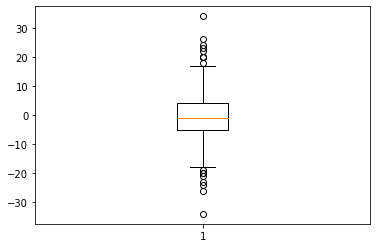

In [160]:
# see spread of point margins
_ = plt.boxplot(df_transformed["point_margin"])

In [177]:
# get values for IQR of point margins 
q75, q25 = np.percentile(df_transformed['point_margin'], [75 ,25])
iqr = q75 - q25
iqr

9.0

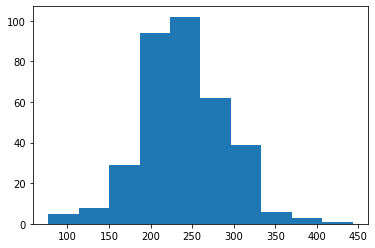

In [161]:
# histogram of catches 
_ = plt.hist(df_transformed["catches"])

In [143]:
wins = dict()
for index, row in df_transformed.iterrows():
    team1 = row["game_title"].split(" ")[0]
    score = row["score"]
    wins[team1] = wins.get(team1, 0) + (1 if score[0] > score[1] else 0)

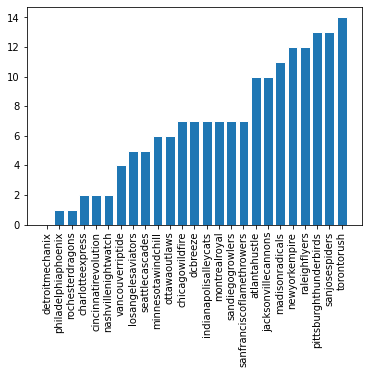

In [144]:
# plot number of wins by team 
wins_sorted = dict(sorted(wins.items(), key=lambda item: item[1]))
plt.bar(wins_sorted.keys(), wins_sorted.values(), edgecolor="white")
_ = plt.xticks(rotation=90)

Text(0.5, 1.0, 'Games played by date')

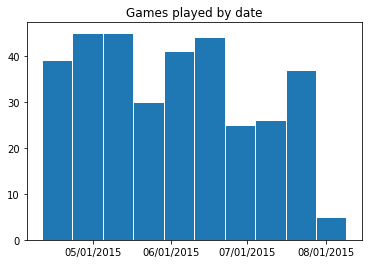

In [145]:
# explore dates of games played 
times = set()
for datestring in df["Date/Time"]:
    date_obj = datetime.strptime(datestring, '%Y-%m-%d %H:%M')
    times.add(date_obj)
    
dates = list()
for time in times:
    dates.append(time.date())

plt_times = mdates.date2num(dates)
plt.hist(plt_times, edgecolor="white")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.title("Games played by date")

In [43]:
print("first game played, " + str(min(dates)) + "\nlast game played: " + str(max(dates)))

first game played, 2015-04-11
last game played: 2015-08-09


<AxesSubplot:>

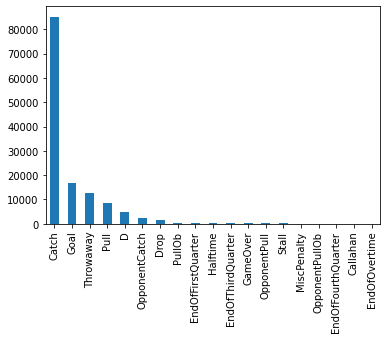

In [146]:
# get frequency of each action 
actions = df["Action"]
actions.value_counts().plot(kind="bar")

In [83]:
# now, start actual training of model 
# we want to predict the point margin of a game given the number of each type of action from a team 

In [147]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split 

In [166]:
x = df_transformed.loc[:, "catches":"stall"]
x_norm = (x-x.min())/(x.max()-x.min())
y = df_transformed["point_margin"]
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2)

In [167]:
linearModel = LinearRegression()
linearModel.fit(x_train, y_train)

LinearRegression()

In [175]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE: " + str(mean_squared_error(y_test, linearModel.predict(x_test))))
print("MAE: " + str(mean_absolute_error(y_test, linearModel.predict(x_test))))

MSE: 33.474065222340904
MAE: 4.614417989271571


In [205]:
# find outlier
diff = y_test - linearModel.predict(x_test)
index_maxdiff = np.argmax(diff)

print(linearModel.predict(x_test)[index_maxdiff])
print("the stats recorded for this outlier game:")
for index, row in df_transformed.iterrows():
    if row.name == 262:
        print(row)
print(df_transformed[df_transformed["game_title"] == "torontorush v. rochesterdragons, 2015-06-27"])

-29.463812750237476
the stats recorded for this outlier game:
game_title      rochesterdragons v. torontorush, 2015-06-27
catches                                                 183
ds                                                       11
throwaways                                               73
drop                                                     26
stall                                                     1
score                                              (10, 27)
point_margin                                            -17
Name: 262, dtype: object
                                      game_title  catches  ds  throwaways  \
320  torontorush v. rochesterdragons, 2015-06-27      169  21          67   

     drop  stall     score  point_margin  
320    19      0  (27, 10)            17  


In [169]:
linearModel.coef_

array([ -8.33827591,  28.8145142 , -14.07339812, -22.55111549,
        -3.03655762])

In [ ]:
# get both opponent's and your stats for a row 

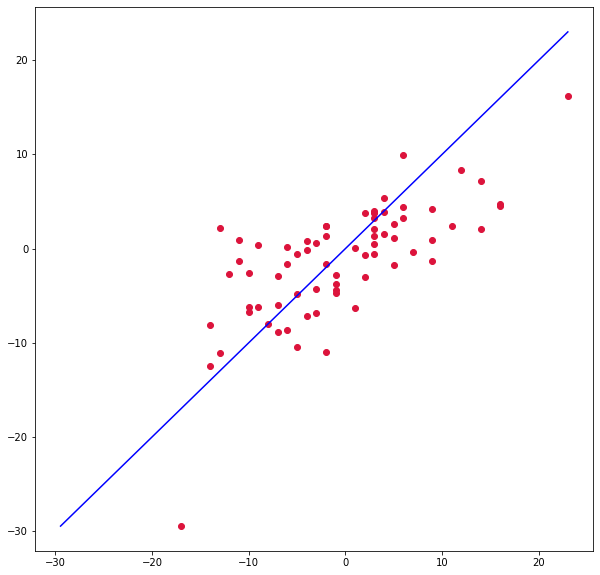

In [170]:
# plot predicted v.s. true value 
true_value = y_test 
predicted_value = linearModel.predict(x_test)

plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='crimson')
p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
_ = plt.plot([p1, p2], [p1, p2], 'b-')


In [178]:
from scipy import stats
stats.pearsonr(predicted_value, true_value)

(0.7112286086015708, 5.218262882983995e-12)